# Data Wrangling - Open Street Map Lima

In this report we document the process of wrangling open street map data for the city of Lima, Peru. 

Given that I have lived in the city for most of my adult life, I thought it was interesting checking up how much data is available in the map. Also, first hand knowledge of the city and language proves advantageous when assessing data's quality. 
## Data origin and general characteristics

The data was obtained [here](https://mapzen.com/data/metro-extracts/metro/lima_peru/). We selected the OSM XML file. The uncompressed file has 140.4 Mb. 

## Problems encountered

Here, we lay out some problems encountered when reviewing the data:

- **Problems with accents ("´")**: As the data is in Spanish, there is some disagreement between some entries. In some, accents are respected, while in others, no accents are displayed. This generates problems when using aggregations methods. In this cases, while both entries point out to the same observation, because of lack of uniformity, it is taken as two different instances.

- **Problems with streets**: We found some lack of uniformity when describing streets. For example, it is possible to find "Ave", "Ave." and "Avenida". While they clearly refer to the same thing, lack of uniformity may lead to confusion.

Closer data analysis for banks and fast food: We wanted to perform an analysis of banks and fast foods in Lima. For this purpose we found all the corresponding tags and names of fast food and banks. A further analysis of them revealed the following problems:

- **Inconsistent names**: Banks revealed multiple names. The same bank or fast food may have sometimes more than one name pointing to it.

- **Inconsisten tagging**: some banks or fast food are not appropriately tagged as a fast food or a bank. For example, for the case of fast food, some times they appear in the restaurant category. This may lead to problematic analysis because categories are not clearly lay out or overlapping.


## Solutions implemented

Before loading the data into a SQL data base, we wanted to ensure that the data was of a quality that rendered our analysis useful. For each of the problems identified above, we implemented the following solutions:

- **Solving for accents**: We decided that the best way to standardized our data was to remove every accent from it. For this purpose, first, we encoded our data as unicode and then remove all the accents from it.

- **Solving for street names**: We performed a review of the data to check how street names are being stored. From these analysis we identified some inconsistences. We solve the inconsistencies choosing a uniform pattern, where appropriate.

- **Inconsistent names**: as part of our bank/fast food analysis, we created a list with the names of banks and tried to solved the multiple instances for the same name problem.

- **Inconsistencies with tagging**: we solved the problem for tagging for banks and fast food giving the appropriate tagging when one is not given. In the case of fast food tagged as restaurants, we applied the rule that if a given restaurant is in our common list of fast food, then their label should be corrected as fast food.

It is important to notice that all of the cleaning and processing stages of the data are available in the [following notebook](https://github.com/jlcoto/Udacity/blob/master/data_wrangling/Open_Street_project/Open_street_lima_project/Project_Lima.ipynb). The notebook identifies steps taken in the cleaning and parsing process.  

## Connecting to database and querying

After connecting to the database and creating the corresponding tables, here we start with our queries. We will use python to perform the queries. First, we check the corresponding size of our data base.  Afterwards, we print the tables available with their corresponding schemas. 

In [2]:
import os
import sqlite3
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
print "Database size:"
print os.path.getsize('lima_project')
print "Original File Size:"
print os.path.getsize('lima_peru.osm')

Database size:
87912448
Original File Size:
140429413


As we can see, our final data set is over 50 Mb. Note that the decompressed and unparsed XML file was over 140 Mb. That is, the parsing and passing to a SQL database has reduced the file size almost to half of its size.

In [3]:
db = sqlite3.connect("lima_project")
c = db.cursor()
c.execute("SELECT sql FROM sqlite_master WHERE type = 'table';")
schemas = c.fetchall()
for i in schemas:
    print i
    print "\n"

(u'CREATE TABLE Nodes (id INTEGER PRIMARY KEY, lat REAL, lon REAL, user TEXT, uid INTEGER, version INTEGER, changeset INTEGER, timestamp DATETIME)',)


(u'CREATE TABLE Node_tags (id INTEGER, key TEXT, value TEXT, type TEXT, FOREIGN KEY(id) REFERENCES Nodes(id))',)


(u'CREATE TABLE Ways (id PRIMARY KEY, user TEXT, uid INTEGER, version INTEGER, changeset INTEGER, timestamp DATETIME)',)


(u'CREATE TABLE Ways_tags (id INTEGER, key TEXT, value TEXT, type TEXT, FOREIGN KEY (id) REFERENCES Ways(id))',)


(u'CREATE TABLE Ways_nodes (id INTEGER, node_id INTEGER, position INTEGER, FOREIGN KEY (id) REFERENCES Ways(id))',)




As it is possible to observe in the output, we have created 5 tables:
1. Nodes
2. Node_tags
3. Ways
4. Ways_nodes
5. Ways_tags

## Data overview

Here we will present basic information about the data collected. In particular, we will query to know:
1. Number of unique users.
2. Number of nodes and ways in data set.
3. Number of amenities.

In [4]:
c.execute("""SELECT count(*) 
          FROM (SELECT DISTINCT uid 
          FROM Nodes UNION SELECT DISTINCT uid FROM Ways);""")
rows = c.fetchall()
print rows[0][0]

912


As it is possible to observe from the query below, the nodes and ways are created by 912 users. We will check later if collaborations are equally distributed across users or if there are only some who have a great number of entries. Next, we check the number of nodes and ways in our data set. 

In [5]:
print "Number of Nodes"
c.execute("""SELECT count(*) FROM Nodes;""")
rows = c.fetchall()
print rows[0][0]
print "\nNumber of Ways"
c.execute("""SELECT count(*) FROM Ways;""")
rows = c.fetchall()
print rows[0][0]


Number of Nodes
567412

Number of Ways
118755


As it is possible to see, our data set is composed by more nodes than ways. In total, we have 567412 nodes and 118755 number of ways.

Another thing that might be important to check is who are the main contributors of Open Street maps for Lima. This might be important in terms or future development. If responsibility only relies on a few users, then the viability of the map might be at risk.

In [6]:
print "Total Number of Nodes"
c.execute("""SELECT count(*) FROM Nodes;""")
rows = c.fetchall()
print rows[0][0] 
print"\nContributions per User "
c.execute("""SELECT user, count(*) 
             FROM Nodes 
             GROUP BY uid 
             ORDER BY count(*) DESC LIMIT 20;""")
rows = c.fetchall()
for row in rows:
    print row[0],  row[1]

Total Number of Nodes
567412

Contributions per User 
Diego Sanguinetti 111712
ovruni 107103
BikeRoad 28354
Te-Ika 21213
JAAS 18988
Baconcrisp 18063
Ranger444 15291
bpowell1 14991
dbusse 13530
Rub21 12524
Corban8 11078
Porphyrion 10946
Balaïtous 10628
MintCondition 10384
johnarupire 9379
ILikeTurtles512 8835
BlueSombra 8772
Tyanna Eaton 8465
pieleric 7505
FoxyMarcie 6623


It is interesting to observe that the total number of nodes in the data set is 567412. If we only take into account the top two contributors, this means that 38.56% of the entries for nodes belong only to these two top contributors. This is quite striking, if we take into account that there are more than 900 contributors. 

In order to have a picture of how the distribution of collaborations looks like, we can plot it using pandas and seaborn.

In [7]:
df_nodes_contrib = pd.read_sql("""SELECT user, count(*) as num_cont 
                                  FROM Nodes 
                                  GROUP BY uid 
                                  ORDER BY num_cont """, con=db) 

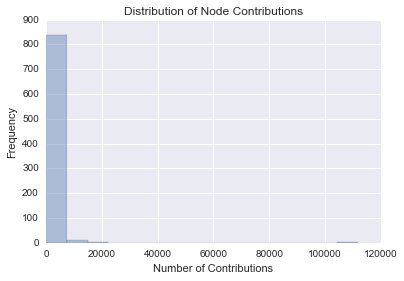

In [8]:
%matplotlib inline
fig, ax = plt.subplots()
sns.distplot(df_nodes_contrib["num_cont"], bins=15, kde=False, ax=ax)
ax.set_title("Distribution of Node Contributions")
ax.set_xlabel("Number of Contributions")
ax.set_ylabel("Frequency")

Even though our query results were already telling, the distribution gives us a clear idea how skewed these values are. Basically all contributors are in the lower end of the distribution. It is also possible to observe a small bar to the right of 100000. This is the one corresponding to our top two contributors. This values are quite far away from the rest of the distribution.

Below, we perform the same analysis for the ways.

In [9]:
print "Total Number of Ways"
c.execute("""SELECT count(*) FROM Ways;""")
rows = c.fetchall()
print rows[0][0] 
print"\nContributions per User "
c.execute("""SELECT user, count(*) 
             FROM Ways 
             GROUP BY uid 
             ORDER BY count(*) DESC LIMIT 20;""")
rows = c.fetchall()
for row in rows:
    print row[0],  row[1]

Total Number of Ways
118755

Contributions per User 
Diego Sanguinetti 20560
ovruni 8848
BlueSombra 6908
Baconcrisp 6127
BikeRoad 6052
Canyonsrcool 5495
Rub21 5250
Ranger444 4697
Te-Ika 4515
bpowell1 4377
Tyanna Eaton 3890
JAAS 3521
Corban8 3367
GRPIAA2 3326
ILikeTurtles512 3211
dbusse 2233
MintCondition 1943
FoxyMarcie 1681
johnarupire 1466
Porphyrion 1252


The story, here, is quite similar as the one with nodes. The same two positions are occupied by the same users. Again, here, there is an important difference between the first place and the rest. However, in this case, the top two positions accumulate roughly more than 24% of the total entries. This means, at least in comparison with nodes, that here contributions are more spread out between users. We plot the distribution below.

In [10]:
df_ways_contrib = pd.read_sql("""SELECT user, count(*) as num_cont 
                                  FROM Ways 
                                  GROUP BY uid 
                                  ORDER BY num_cont """, con=db) 

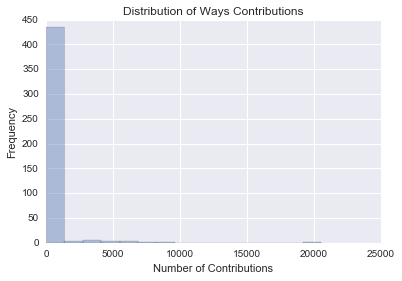

In [11]:
fig, ax = plt.subplots()
sns.distplot(df_ways_contrib["num_cont"], bins=15, kde=False, ax=ax)
ax.set_title("Distribution of Ways Contributions")
ax.set_xlabel("Number of Contributions")
ax.set_ylabel("Frequency")

While, as nodes, ways also is quite skewed to the left, it is also possible to observed that the difference between low and high values is not as extreme as before. Also, there are a number of intermediate values that in the other distribution was not possible to observe.

In order to have a more clear idea of how contributions behave, we can also check the number of unique contributors per dataset. This will be a good indicator of fidelity. 

In [12]:
print "Unique contributors Nodes:"
c.execute("""SELECT sum(counter) 
             FROM (SELECT count(*) as counter 
             FROM Nodes GROUP BY uid 
             HAVING counter=1);""")
rows = c.fetchall()
print rows[0][0]

print "\nUnique contributors Ways:"
c.execute("""SELECT sum(counter) 
             FROM (SELECT count(*) as counter 
             FROM Ways GROUP BY uid 
             HAVING counter=1);""")
rows = c.fetchall()
print rows[0][0]

Unique contributors Nodes:
257

Unique contributors Ways:
133


Note that for the nodes dataset we can see that approximately 30% of contributors only does it once. In the case of the Ways this amount is even higher. 56.73% only contributes once. This speaks to the necessity of reinforcing the community or establish some kind of incentive in order to assure more active contributors.

In [13]:
#Top amenities in data set
c.execute("""SELECT value, count(*) as counter 
             FROM Node_tags WHERE key="amenity" 
             GROUP BY value 
             ORDER BY counter DESC 
             LIMIT 15;""")
rows = c.fetchall()
for row in rows:
    print "{} | {}".format(row[0],  row[1])

restaurant | 1934
pharmacy | 1408
dentist | 536
bank | 523
school | 474
fast_food | 258
cafe | 251
place_of_worship | 207
kindergarten | 188
parking | 165
veterinary | 161
fountain | 152
bench | 138
fuel | 134
clinic | 130


It is interesting to see that the top amenity in the dataset are restaurants. A fact that I found surprising is that there are only 474 tags corresponding to school. This quantity seems a bit small considering that Lima has around 10 million inhabitants. There might be a reason here to suspect incorrect or lack of tagging or lack of data. 

## Analyzing banks

During our data cleaning process, we put extra emphasis in cleaning the data relative to banks. In particular, we strived to give some uniformity to our bank data. Here, we want to proceed with our analysis. In particular, we are interested to determine which bank has a bigger presences in Lima.

In [14]:
c.execute("""SELECT bank_vals.value, count(*) 
             FROM Node_tags JOIN (SELECT id, value FROM Node_tags WHERE key="name") as bank_vals 
             ON bank_vals.id=Node_tags.id WHERE Node_tags.value="bank" 
             GROUP BY bank_vals.value 
             ORDER BY count(*) DESC 
             LIMIT 10;""")
rows = c.fetchall()
print "Bank| Count"
for row in rows:
    print "{} | {}".format(row[0],  row[1])

Bank| Count
BCP | 101
BBVA | 82
Interbank | 80
Banco de la Nacion | 68
Scotiabank | 42
Western Union | 20
Financiero | 19
Azteca | 15
BIF | 15
Mi Banco | 15


Aligned with what was expected, the BCP has more banks in the city. It has almost 20 more banks than its closest rival: BBVA. It is also interesting that the State Owned Bank, Banco de la Nacion, is in 4th position with a relevant number of banks in the city. 

Note, also, that our recoding of names appear to have been successful for the banks. At least within the tops we do not have two names that point to the same bank. However, there are some corner cases that have escaped our coding solution. This cases have to do with poor data entry by the user.

In order to better see the distribution of banks in the city, we plotted the locations of the maps in Lima's map.

In [15]:
#Importing necessary libraries for plotting
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
import geopandas as gp
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
from itertools import cycle

To correctly plot the locations of maps, we needed to work with the city's shapefile. We found the shapefile in this [governmental web page](http://www.geogpsperu.com/2014/03/base-de-datos-peru-shapefile-shp-minam.html). Also, our plotting solution is based on this [blog post](http://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html#.V-jkeJN95AY).

In [16]:
#Creating maps from existing shapefile
shp = gp.GeoDataFrame.from_file('BAS_LIM_DISTRITOS.shp')

In [17]:
shp_lima = shp.query("'LIMA' in NOMBDEP and 'LIMA' in NOMBPROV")
shp_lima_callao = shp_lima.append(shp.query("'CALLAO' in NOMBDEP"))
shp_lima_callao = shp_lima_callao.to_crs({'init': 'epsg:4326'})
shp_lima_callao.to_file('Lima_4326.shp', driver='ESRI Shapefile')
coords = shp_lima_callao.bounds[["minx", "miny"]].min().append(shp_lima_callao.bounds[["maxx", "maxy"]].max())
w, h = coords[2] - coords[0], coords[3] - coords[1]
extra = 0.01
m = Basemap(
    projection='tmerc', ellps='WGS84',
    lon_0=-77.028333,
    lat_0=-12.043333,
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - (extra * h), 
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + (extra * h),
    resolution='i',  suppress_ticks=True)
m.readshapefile('Lima_4326', name='Lima', drawbounds=False, color='none', zorder=2)

#Creating map coordinates and plotting values
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.Lima],
    'distrito': [distrito['NOMBDIST'] for distrito in m.Lima_info]})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000

We are interested in plotting two things: first, we want to obtain a general overview of where banks are located. Second, we want to see where the top 5 banks are located. We generate the corresponding plotting function and the data sets that we will use for plotting purposes.

In [18]:
def point_plotter(lon, lat, df_map=df_map):
    """Given lat and lon coordinates translates point into mapping area
    for plotting purposes.
    """
    map_points = pd.Series([Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(lon, lat)])
    plaque_points = MultiPoint(list(map_points.values))
    district_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
    lima_points = filter(district_polygon.contains, plaque_points)
    lima_pol = pd.Series([Polygon(xy) for xy in m.Lima])
    x_points = pd.Series([geom.x for geom in lima_points])
    y_points = pd.Series([geom.y for geom in lima_points])
    return x_points, y_points

def map_drawer(ax, lon, lat, title="", df_map=df_map):
    "General plotting function for all points in data set."
    df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#C1BFBB',
    ec='#FFFFFF', lw=.25, alpha=.9,
    zorder=4))
    plt.clf()
    ax = plt.gca()
    ax.set_axis_bgcolor('white')
    x_point_series, y_point_series =  point_plotter(lon, lat, df_map=df_map)
    dev = m.scatter(
    x_point_series,
    y_point_series,
    5, marker='o', lw=.25,
    facecolor='#60A0EA', edgecolor='#1061C1',
    alpha=0.9, antialiased=True,
    zorder=3)
    ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))
    ax.set_title(title, fontsize=15)

def map_drawer_categories(ax, df_to_plot, cat_to_plot,
                          categories, list_of_colors, title="", df_map=df_map):
    """Scatter plot with different color of points by category given."""
    df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#C1BFBB',
    ec='#FFFFFF', lw=.25, alpha=.9,
    zorder=4))

    #plt.clf()
    ax = plt.gca()
    ax.set_axis_bgcolor('white')
    ax = fig.add_subplot(122, axisbg='w', frame_on=False)
    
    cat_colors = cycle(list_of_colors)
    for category in categories:
        plot_cat = df_to_plot[df_to_plot[cat_to_plot] == category]
        x_point_series, y_point_series = point_plotter(plot_cat['lon'], plot_cat['lat'])
        dev = m.scatter(
            x_point_series,
            y_point_series,
            7,
            color = next(cat_colors),
            zorder=3,
            alpha=0.8, 
            label= category
        )
        
    ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))
    ax.set_title(title, fontsize=15)
    ax.legend(loc='upper center', bbox_to_anchor=(0.6, 0), fancybox=True, shadow=True, ncol=2)

Having implemented our plotting functions, we now need to prepare the data that we want to plot. Note that, for this, we need to do a further data query. We pass our data query to a pandas data fram structure, so we can easily and seamlessly use Basemap matplotlib plotting utilities.


In [19]:
df_banks = pd.read_sql("""SELECT *
             FROM Node_tags JOIN (SELECT id, value FROM Node_tags WHERE key="name") as bank_vals 
             ON bank_vals.id=Node_tags.id, Nodes WHERE Node_tags.value="bank" and Nodes.id=Node_tags.id 
            """, con=db) 

As we also want to have a plot for the top banks, we generate a smaller data set where only the bigger banks will be selected. Note that here we understand as top bank those banks that have more than 40 branches in the city. We also define a list of colors, so each of our banks can receive a different color when plotting.

In [20]:
df_banks["bank_names"] = df_banks["value"].iloc[:, 1]
df_banks = df_banks.drop(df_banks["value"], axis=1)

In [21]:
plot_top_banks = df_banks.groupby(df_banks["bank_names"]).filter(lambda x: len(x) >= 40)
list_top_banks = pd.unique(plot_top_banks["bank_names"])
#reverse list of colors corresponding to each of the banks
bank_colors = ["#FB6502", "#468ACE", "#79229B", "#359D3D", "#EDF277"][::-1]

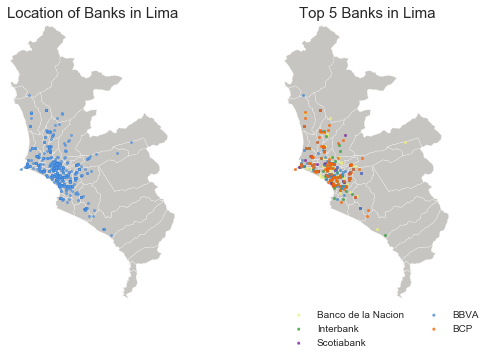

In [22]:
fig, ax = plt.subplots(2, figsize=(18,5))
map_drawer(ax[0], df_banks['lon'], df_banks['lat'], title="Location of Banks in Lima")
map_drawer_categories(ax[1], plot_top_banks, "bank_names", list_top_banks[::-1], 
                      bank_colors, title="Top 5 Banks in Lima")

In the figures we can see how highly concentrated banks are in the core center of Lima. On the periphery, we can hardly observed any bank. It would be interesting to check if this is correlated with the population density or income of the population in each area.


## Analyzing Fast Food

We continue our analysis, but now, we do it for the fast food restaurants. In particular, we want to know what is the most popular fast food in Lima.

In [23]:
c.execute("""SELECT fast_food_vals.value, count(*) 
             FROM Node_tags JOIN (SELECT id, value FROM Node_tags WHERE key="name") as fast_food_vals 
             ON fast_food_vals.id=Node_tags.id WHERE Node_tags.value="fast_food" 
             GROUP BY fast_food_vals.value 
             ORDER BY count(*) DESC 
             LIMIT 10;""")
rows = c.fetchall()
print "Fast Food| Count"
for row in rows:
    print "{} | {}".format(row[0],  row[1])

Fast Food| Count
Norky's | 32
Rocky's | 26
KFC | 25
Pizza Hut | 21
Bembos | 20
McDonald's | 11
Popeye's | 7
Subway | 7
China Wok | 6
Papa John's | 6


Contrary to what we expected, the most common fast food is a Grilled Chicken franchise called Norky's. Rocky's closely follows with 26 stores. Note that KFC, a big international brand comes in third place. Apparently, the preferences of "Limeños" tend to favor local brands over international ones. However, we are not able to say if this is just a matter of quality of data (because there were more entries for Norky's) or if this actually follows from reality. 

While our coding solution did a good job giving uniformity to the data, we could still found some entries that were not correctly categorized. Correcting these entries would demand defining more comprehensive correction rules. Note, however, that even taking these errors into account, our results in terms of the ranking will not vary.

As we did with the banks, we also want to have here a map plot to observe if there are some clustering patterns with respect to fast foods. We make use of our plotting functions previously defined.

In [24]:
df_fast_food = pd.read_sql("""SELECT *
             FROM Node_tags JOIN (SELECT id, value FROM Node_tags WHERE key="name") as fast_food_vals 
             ON fast_food_vals.id=Node_tags.id, Nodes WHERE Node_tags.value="fast_food" and Nodes.id=Node_tags.id 
            """, con=db) 

In [25]:
df_fast_food["food_names"] = df_fast_food["value"].iloc[:, 1]
df_fast_food = df_fast_food.drop(df_fast_food["value"], axis=1)

Again, we also want to plot those fast food restaurants that have more facilities in the city. We operationalize top fast food restaurants as the ones that have 10 or more restaurants in the city.

In [26]:
plot_top_fast_food = df_fast_food.groupby(df_fast_food["food_names"]).filter(lambda x: len(x) >= 10)
list_top_fast_food = pd.unique(plot_top_fast_food["food_names"])
list_top_fast_food

array([u'Bembos', u"Norky's", u"McDonald's", u"Rocky's", u'KFC',
       u'Pizza Hut'], dtype=object)

In [27]:
#Plotting all fast food and only ones that have more than 10 shops.
rest_color_pal = sns.color_palette("Set1")

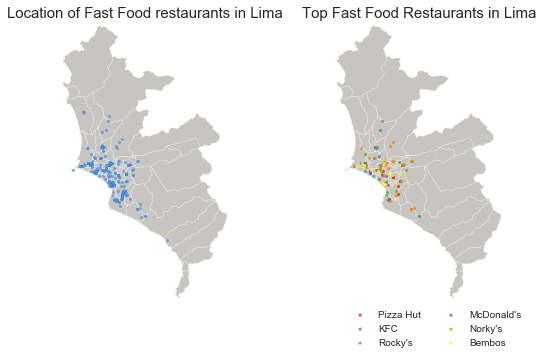

In [28]:
fig, ax = plt.subplots(2, figsize=(18,5))
map_drawer(ax[0], df_fast_food['lon'], df_fast_food['lat'], title="Location of Fast Food restaurants in Lima")
map_drawer_categories(ax[1], plot_top_fast_food, "food_names", list_top_fast_food[::-1], 
                      rest_color_pal, title="Top Fast Food Restaurants in Lima")

Once again, the same pattern of most fast food locating in the middle of the city is observed. As we mentioned before, this might be correlated with income or population density. However, we would need to more data to explore these hypotheses.

## Limitations and conclusions

In this report we have looked at the Open Street data for the city of Lima, Peru. We obtained the data as a XML file and correspondingly scraped it into a CSV format. During the process of extraction we took into consideration problems with accents and streets. This was relevant for assuring standarization of the data.

Furthermore, given that we wanted to perform a more precise analysis of banks and fast foods, we put special emphasis on normalizing these data. This followed two steps: making sure that main banks or fast foods' names followed certain uniformity and that the value tags correspondingly include their category. We took special care in documenting and testing each step of the process. More information can be accessed [here](https://github.com/jlcoto/Udacity/blob/master/data_wrangling/Open_Street_project/Open_street_lima_project/Project_Lima.ipynb).

We started our report giving a series of data relevant to the data set and also more specific to the banks and restaurants. However, we should also take into consideration the limitations of the analysis:

1. It is not possible to say how much coverage or detail has the data of the actual city. Therefore, things as the rankings are only relevant in so far as the underlying data is meaningful.
2. The process of cleaning and making sure that the data is of a certain quality is specially difficult with user entry data. While we have tried to overcome quite relevant and noticeable problems with the data (as with the accents), it is not possible to guarantee that there are no remaining untreated errors. For example, even when we put extra care with the banks and restaurants, we could find that our solution, while good, was not perfect.
3. The data is not correctly categorized. As seen with fast food, there does not appear to be clear rules when clasifying a restaurant as a fast food or a restaurant. We observed the same thing for schools (some universities or offices were classified as such). A careful user of the data base should first scrutinize the tag that she wants to investigate and check if their treatment is uniform across the data.

Having focused on the problems, there are still a series of improvements available:

1. While it is impossible to say, per se, how much coverage the data set has, it would be interesting to contrast its entries to other mapping apis, like Google Maps. Of course, this option may not be available given copyright or patent issues. However, there are other things that might be possible. For example, as we observed, the number of schools appears to be low. Here there is space for some data accuracy. The Peruvian Ministry of Education has available in its website the list of all schools in Lima with their appropriate latitude and longitude coordinates. This can be an interesting source for data comparison.
2. There is no easy solution for the cleaning process. This entails reitarating through the steps of checking your data, catching the mistakes and correcting them again. However, efforts can be made to reduce data entry errors. Perhaps by making sure users follow certain patterns or recommending them normally used options when entering data (for example, if the data entry is a bank show the user top 10 banks with more entries so she can choose from them without typing its entry).
3. This only depends on how careful the data base user is to detect some contradictions. Still, as said before, some of these errors could be reduced in the entry stage.

